In [12]:
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
from collections import OrderedDict
from easydict import EasyDict
import argparse
import os
import matplotlib.pyplot as plt
import pandas as pd
from _main_base import *

#---
# config
#---
cfg = EasyDict()

# class
cfg.CLASS_LABEL = ['akahara', 'madara'] # list, dict('label' : '[B, G, R]')
cfg.CLASS_NUM = len(cfg.CLASS_LABEL)

# model
cfg.INPUT_Z_DIM = 100
cfg.INPUT_MODE = None

cfg.OUTPUT_HEIGHT = 64
cfg.OUTPUT_WIDTH = 64
cfg.OUTPUT_CHANNEL = 3
cfg.OUTPUT_MODE = 'RGB'  # RGB, GRAY, EDGE, CLASS_LABEL

cfg.G_DIM = 64
cfg.D_DIM = 64

cfg.CHANNEL_AXIS = 1 # 1 ... [mb, c, h, w], 3 ... [mb, h, w, c]

cfg.GPU = False
cfg.DEVICE = torch.device('cuda' if cfg.GPU and torch.cuda.is_available() else 'cpu')

# train
cfg.TRAIN = EasyDict()
cfg.TRAIN.DISPAY_ITERATION_INTERVAL = 50

cfg.PREFIX = 'DCGAN'
cfg.TRAIN.MODEL_G_SAVE_PATH = 'models/' + cfg.PREFIX + '_G_{}.pt'
cfg.TRAIN.MODEL_D_SAVE_PATH = 'models/' + cfg.PREFIX + '_D_{}.pt'
cfg.TRAIN.MODEL_SAVE_INTERVAL = 200
cfg.TRAIN.ITERATION = 5000
cfg.TRAIN.MINIBATCH = 32
cfg.TRAIN.OPTIMIZER_G = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS_G = {'lr' : 0.0002, 'betas' : (0.5, 0.9)}
cfg.TRAIN.OPTIMIZER_D = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS_D = {'lr' : 0.0002, 'betas' : (0.5, 0.9)}
cfg.TRAIN.LOSS_FUNCTION = loss_fn = torch.nn.BCELoss()

cfg.TRAIN.DATA_PATH = '../../Dataset/train/images/'
cfg.TRAIN.DATA_HORIZONTAL_FLIP = True # data augmentation : holizontal flip
cfg.TRAIN.DATA_VERTICAL_FLIP = False # data augmentation : vertical flip
cfg.TRAIN.DATA_ROTATION = False # data augmentation : rotation False, or integer

cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE = True
cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL = 500
cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'
cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH = 'result/' + cfg.PREFIX + '_loss.txt'

# test
cfg.TEST = EasyDict()
cfg.TEST.MODEL_G_PATH = cfg.TRAIN.MODEL_G_SAVE_PATH.format('final')
cfg.TEST.DATA_PATH = '../../Dataset/test/images/'
cfg.TEST.MINIBATCH = 10
cfg.TEST.ITERATION = 2
cfg.TEST.RESULT_SAVE = False
cfg.TEST.RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'

# random seed
torch.manual_seed(0)


# make model save directory
def make_dir(path):
    if '/' in path:
        model_save_dir = '/'.join(path.split('/')[:-1])
        os.makedirs(model_save_dir, exist_ok=True)

make_dir(cfg.TRAIN.MODEL_G_SAVE_PATH)
make_dir(cfg.TRAIN.MODEL_D_SAVE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)
    


class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.module = torch.nn.Sequential(OrderedDict({
            'G_layer_1' : torch.nn.ConvTranspose2d(cfg.INPUT_Z_DIM, cfg.G_DIM * 8, kernel_size=[cfg.OUTPUT_HEIGHT // 16, cfg.OUTPUT_WIDTH // 16], stride=1, bias=False),
            'G_layer_1_bn' : torch.nn.BatchNorm2d(cfg.G_DIM * 8),
            'G_layer_1_ReLU' : torch.nn.ReLU(),
            'G_layer_2' : torch.nn.ConvTranspose2d(cfg.G_DIM * 8, cfg.G_DIM * 4, kernel_size=4, stride=2, padding=1, bias=False),
            'G_layer_2_bn' : torch.nn.BatchNorm2d(cfg.G_DIM * 4),
            'G_layer_2_ReLU' : torch.nn.ReLU(),
            'G_layer_3' : torch.nn.ConvTranspose2d(cfg.G_DIM * 4, cfg.G_DIM * 2, kernel_size=4, stride=2, padding=1, bias=False),
            'G_layer_3_bn' : torch.nn.BatchNorm2d(cfg.G_DIM * 2),
            'G_layer_3_ReLU' : torch.nn.ReLU(),
            'G_layer_4' : torch.nn.ConvTranspose2d(cfg.G_DIM * 2, cfg.G_DIM, kernel_size=4, stride=2, padding=1, bias=False),
            'G_layer_4_bn' : torch.nn.BatchNorm2d(cfg.G_DIM),
            'G_layer_4_ReLU' : torch.nn.ReLU(),
            'G_layer_out' : torch.nn.ConvTranspose2d(cfg.G_DIM, cfg.OUTPUT_CHANNEL, kernel_size=4, stride=2, padding=1, bias=False),
            'G_layer_out_tanh' : torch.nn.Tanh()
        }))

    def forward(self, x):
        x = self.module(x)
        return x

class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.module = torch.nn.Sequential(OrderedDict({
            'D_layer_1' : torch.nn.Conv2d(cfg.OUTPUT_CHANNEL, cfg.D_DIM, kernel_size=5, padding=2, stride=2),
            'D_layer_1_leakyReLU' : torch.nn.LeakyReLU(0.2),
            'D_layer_2' : torch.nn.Conv2d(cfg.D_DIM, cfg.D_DIM * 2, kernel_size=5, padding=2, stride=2),
            'D_layer_2_leakyReLU' : torch.nn.LeakyReLU(0.2),
            'D_layer_3' : torch.nn.Conv2d(cfg.D_DIM * 2, cfg.D_DIM * 4, kernel_size=5, padding=2, stride=2),
            'D_layer_3_leakyReLU' : torch.nn.LeakyReLU(0.2),
            'D_layer_4' : torch.nn.Conv2d(cfg.D_DIM * 4, cfg.D_DIM * 8, kernel_size=5, padding=2, stride=2),
            'D_layer_4_leakyReLU' : torch.nn.LeakyReLU(0.2),
            'D_layer_out' : torch.nn.Conv2d(cfg.D_DIM * 8, 1, kernel_size=[cfg.OUTPUT_HEIGHT // 16, cfg.OUTPUT_WIDTH // 16], padding=0, stride=1, bias=False),
            'D_layer_out_sigmoid' : torch.nn.Sigmoid()
        }))

    def forward(self, x):
        x = self.module(x)
        return x


def result_show(G, z, path=None, save=False, show=False):
    if (save or show) is False:
        print('argument save >> {} and show >> {}, so skip')
        return

    Gz = G(z)
    Gz = Gz.detach().cpu().numpy()

    Gz = (Gz * 127.5 + 127.5).astype(np.uint8)
    Gz = Gz.reshape([-1, cfg.OUTPUT_CHANNEL, cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH])
    Gz = Gz.transpose(0, 2, 3, 1)

    for i in range(cfg.TEST.MINIBATCH):
        _G = Gz[i]
        plt.subplot(1, cfg.TEST.MINIBATCH, i + 1)
        plt.imshow(_G)
        plt.axis('off')

    if path is not None:
        plt.savefig(path)
        print('result was saved to >> {}'.format(path))

    if show:
        plt.show()


100%|██████████| 16/16 [00:00<00:00, 26535.73it/s]

Dataset >> ../../Dataset/train/images/
 - Found data num >> 16
 - Horizontal >> True
 - Vertical >> False
 - Rotation >> False
all data num >> 32
dataset was completely loaded
--
training start


Iter:50, LossG (fake:6.6678), LossD:0.8173 (real:0.8158, fake:0.0015)
Iter:100, LossG (fake:0.6901), LossD:1.4791 (real:0.4637, fake:1.0154)
Iter:150, LossG (fake:1.2503), LossD:0.7623 (real:0.3692, fake:0.3931)
Iter:200, LossG (fake:1.0522), LossD:0.7040 (real:0.2040, fake:0.5000)
save G >> models/DCGAN_G_iter200.pt, D >> models/DCGAN_D_iter200.pt
Iter:250, LossG (fake:1.5600), LossD:0.5441 (real:0.2719, fake:0.2721)
Iter:300, LossG (fake:2.3255), LossD:0.3537 (real:0.1957, fake:0.1579)
Iter:350, LossG (fake:2.3049), LossD:0.3099 (real:0.0990, fake:0.2109)
Iter:400, LossG (fake:1.8209), LossD:0.4249 (real:0.0276, fake:0.3973)
save G >> models/DCGAN_G_iter400.pt, D >> models/DCGAN_D_iter400.pt
Iter:450, LossG (fake:1.8493), LossD:0.4577 (real:0.0037, fake:0.4539)
Iter:500, LossG (fake:6.6809), LossD:0.3806 (real:0.3736, fake:0.0070)
result was saved to >> result/DCGAN_result_iter500.jpg
Iter:550, LossG (fake:2.7781), LossD:0.1738 (real:0.0060, fake:0.1677)
Iter:600, LossG (fake:3.6071)

/Users/yoshitonagaoka/.conda/envs/dl_env/lib/python3.7/site-packages/ipykernel_launcher.py:149: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Iter:1050, LossG (fake:7.4057), LossD:0.0145 (real:0.0035, fake:0.0110)
Iter:1100, LossG (fake:6.5998), LossD:0.1180 (real:0.0018, fake:0.1162)
Iter:1150, LossG (fake:4.8808), LossD:0.6192 (real:0.0005, fake:0.6187)
Iter:1200, LossG (fake:12.7000), LossD:0.3579 (real:0.3577, fake:0.0002)
save G >> models/DCGAN_G_iter1200.pt, D >> models/DCGAN_D_iter1200.pt
Iter:1250, LossG (fake:10.6835), LossD:0.2895 (real:0.2815, fake:0.0080)
Iter:1300, LossG (fake:7.3857), LossD:0.0630 (real:0.0042, fake:0.0587)
Iter:1350, LossG (fake:6.0555), LossD:0.1250 (real:0.0868, fake:0.0382)
Iter:1400, LossG (fake:8.0958), LossD:0.0404 (real:0.0355, fake:0.0049)
save G >> models/DCGAN_G_iter1400.pt, D >> models/DCGAN_D_iter1400.pt
Iter:1450, LossG (fake:7.0614), LossD:0.0902 (real:0.0104, fake:0.0799)
Iter:1500, LossG (fake:9.3039), LossD:0.1010 (real:0.0925, fake:0.0086)
result was saved to >> result/DCGAN_result_iter1500.jpg
Iter:1550, LossG (fake:7.9508), LossD:0.0521 (real:0.0453, fake:0.0068)
Iter:1600,

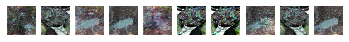

In [4]:
# train
def train():
    # model
    G = Generator().to(cfg.DEVICE)
    D = Discriminator().to(cfg.DEVICE)

    opt_G = cfg.TRAIN.OPTIMIZER_G(G.parameters(), **cfg.TRAIN.LEARNING_PARAMS_G)
    opt_D = cfg.TRAIN.OPTIMIZER_D(D.parameters(), **cfg.TRAIN.LEARNING_PARAMS_D)

    path_dict = data_load(cfg)
    paths = path_dict['paths']
    paths_gt = path_dict['paths_gt']

    # training
    mbi = 0
    train_N = len(paths)
    train_ind = np.arange(train_N)
    np.random.seed(0)
    np.random.shuffle(train_ind)

    list_iter = []
    list_loss_G = []
    list_loss_D = []
    list_loss_D_real = []
    list_loss_D_fake = []

    print('training start')
    progres_bar = ''

    if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
        f = open(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, 'w')
        f.write('iteration,loss_G,loss_G_fake,loss_D,loss_D_real,loss_D_fake\n')
    
    for i in range(cfg.TRAIN.ITERATION):
        if mbi + cfg.TRAIN.MINIBATCH > train_N:
            mb_ind = train_ind[mbi:]
            np.random.shuffle(train_ind)
            mb_ind = np.hstack((mb_ind, train_ind[ : (cfg.TRAIN.MINIBATCH - (train_N - mbi))]))
            mbi = cfg.TRAIN.MINIBATCH - (train_N - mbi)
        else:
            mb_ind = train_ind[mbi : mbi + cfg.TRAIN.MINIBATCH]
            mbi += cfg.TRAIN.MINIBATCH

        opt_D.zero_grad()

        # sample X
        Xs = torch.tensor(get_image(paths[mb_ind], cfg, cfg.INPUT_MODE), dtype=torch.float).to(cfg.DEVICE)

        # sample x
        z = np.random.uniform(-1, 1, size=(cfg.TRAIN.MINIBATCH, cfg.INPUT_Z_DIM, 1, 1))
        z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)

        # forward
        Gz = G(z)
        D_real = D(Xs)[..., 0, 0, 0]
        D_fake = D(Gz)[..., 0, 0, 0]

        # update D
        loss_D_real = cfg.TRAIN.LOSS_FUNCTION(D_real, torch.ones(cfg.TRAIN.MINIBATCH).to(cfg.DEVICE))
        loss_D_fake = cfg.TRAIN.LOSS_FUNCTION(D_fake, torch.zeros(cfg.TRAIN.MINIBATCH).to(cfg.DEVICE))
        loss_D = loss_D_real + loss_D_fake
        loss_D.backward(retain_graph=True)
        opt_D.step()

        # update G
        opt_G.zero_grad()
        loss_G = cfg.TRAIN.LOSS_FUNCTION(D_fake, torch.ones(cfg.TRAIN.MINIBATCH).to(cfg.DEVICE))
        loss_G.backward()
        opt_G.step()


        progres_bar += '|'
        print('\r' + progres_bar, end='')

        _loss_G = loss_G.item()
        _loss_D = loss_D.item()
        _loss_D_real = loss_D_real.item()
        _loss_D_fake = loss_D_fake.item()

        if (i + 1) % 10 == 0:
            progres_bar += str(i + 1)
            print('\r' + progres_bar, end='')

            # save process result
            if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
                list_iter.append(i + 1)
                list_loss_G.append(_loss_G)
                list_loss_D.append(_loss_D)
                list_loss_D_real.append(_loss_D_real)
                list_loss_D_fake.append(_loss_D_fake)

        # display training state
        if (i + 1) % cfg.TRAIN.DISPAY_ITERATION_INTERVAL == 0:
            print('\r' + ' ' * len(progres_bar), end='')
            print('\rIter:{}, LossG (fake:{:.4f}), LossD:{:.4f} (real:{:.4f}, fake:{:.4f})'.format(
                i + 1, _loss_G, _loss_D, _loss_D_real, _loss_D_fake))
            progres_bar = ''

        # save parameters
        if (cfg.TRAIN.MODEL_SAVE_INTERVAL != False) and ((i + 1) % cfg.TRAIN.MODEL_SAVE_INTERVAL == 0):
            G_save_path = cfg.TRAIN.MODEL_G_SAVE_PATH.format('iter{}'.format(i + 1))
            D_save_path = cfg.TRAIN.MODEL_D_SAVE_PATH.format('iter{}'.format(i + 1))
            torch.save(G.state_dict(), G_save_path)
            torch.save(D.state_dict(), D_save_path)
            print('save G >> {}, D >> {}'.format(G_save_path, D_save_path))

        # save process result
        if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE and ((i + 1) % cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL == 0):
            result_show(
                G, z, cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH.format('iter' + str(i + 1)), 
                save=cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE, show=False)

    G_save_path = cfg.TRAIN.MODEL_G_SAVE_PATH.format('final')
    D_save_path = cfg.TRAIN.MODEL_D_SAVE_PATH.format('final')
    torch.save(G.state_dict(), G_save_path)
    torch.save(D.state_dict(), D_save_path)
    print('final paramters were saved to G >> {}, D >> {}'.format(G_save_path, D_save_path))

    if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
        f = open(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, 'w')
        df = pd.DataFrame({'iteration' : list_iter, 'loss_G' : list_loss_G, 'loss_D' : list_loss_D, 'loss_D_real' : list_loss_D_real, 'loss_D_fake' : list_loss_D_fake})
        df.to_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, index=False)
        print('loss was saved to >> {}'.format(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH))
        
train()

--------------------
test function
--------------------
result was saved to >> result/DCGAN_result_1.jpg


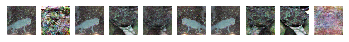

result was saved to >> result/DCGAN_result_2.jpg


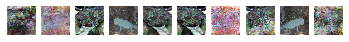

In [13]:
# test
def test():
    print('-' * 20)
    print('test function')
    print('-' * 20)
    G = Generator().to(cfg.DEVICE)
    G.load_state_dict(torch.load(cfg.TEST.MODEL_G_PATH, map_location=torch.device(cfg.DEVICE)))
    G.eval()

    np.random.seed(0)
    
    for i in range(cfg.TEST.ITERATION):
        z = np.random.uniform(-1, 1, size=(cfg.TEST.MINIBATCH, cfg.INPUT_Z_DIM, 1, 1))
        z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)

        result_show(G, z, cfg.TEST.RESULT_IMAGE_PATH.format(i + 1), save=cfg.TEST.RESULT_SAVE, show=True)

test()

In [ ]:
def arg_parse():
    parser = argparse.ArgumentParser(description='CNN implemented with Keras')
    parser.add_argument('--train', dest='train', action='store_true')
    parser.add_argument('--test', dest='test', action='store_true')
    args = parser.parse_args()
    return args

# main
"""
if __name__ == '__main__':
    args = arg_parse()

    if args.train:
        train()
    if args.test:
        test()

    if not (args.train or args.test):
        print("please select train or test flag")
        print("train: python main.py --train")
        print("test:  python main.py --test")
        print("both:  python main.py --train --test")
"""